## Esercizio 11.3

Estendiamo ulteriormente il nostro modello nello spazio 2D per andare a fittare una funzione trigonometrica da $\mathbb{R}^2$ in $\mathbb{R}$:

$$h(x,y) = \sin(x^2+y^2) \quad con\;x\;e \;y \in [-\frac{3}{2},\frac{3}{2}]$$

Avendo due dimensioni in input, l'input shape del modello sara' pari a 2, mentre il layer di output sara' ancora composto da un singolo neurone. 

Come nel precedente caso, data la totale liberta' su come costruire la nostra rete, scegliamo di utilizzare 5 hidden layers, ognuno costituito da 20 neuroni. La rete lavora con batch di 32, un numero di epoche pari a 50, $\;\sigma=0.1$ e $N_{\mathrm{train}}=10000$.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

import numpy as np
import matplotlib.pyplot as plt

def network_model(nr_neurons, nr_layers, choosen_optimizer, choosen_loss, choosen_activation ): 
    #lo costruisco con lo stesso nr di neuroni in ogni layer 
    model = tf.keras.Sequential()
    
    model.add(Dense(nr_neurons, input_shape=(2,),activation=choosen_activation)) #input layer
    
    for i in range(nr_layers): #hidden layers
        model.add(Dense(nr_neurons, activation=choosen_activation))
        
    model.add(Dense(1, activation=choosen_activation)) #output layer
    
    model.compile(optimizer=choosen_optimizer, loss=choosen_loss, metrics=['mse'])
    return model

2023-06-27 14:42:42.067236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Mostriamo, innanzitutto, un confronto tra la funzione target, di cui la rete neurale vorremo riproducesse l'andamento, e il set di punti di validazione, punti estratti attraverso un generatore di numeri casuali uniforme poi sporcati col rumore gaussiano, che il network vedra' solo in fase di validazione.

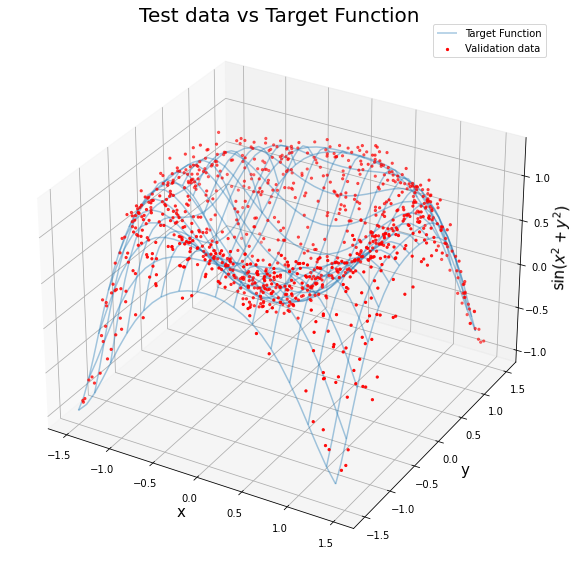

In [6]:
def h(x, y):
    return np.sin(x**2 + y**2)

sigma=0.1 #noise standard deviation

# generate training inputs
np.random.seed(0) #seme generatore di numeri casuali
x_train = np.random.uniform(-3./2, 3./2, 10000)
y_train = np.random.uniform(-3./2, 3./2, 10000)

x_valid = np.random.uniform(-3./2, 3./2, 1000)
y_valid = np.random.uniform(-3./2, 3./2, 1000)
#x_valid.sort() #se sorto non devo plottare
#y_valid.sort()
z_target = h(x_valid, y_valid)

z_train = np.random.normal(h(x_train, y_train), sigma) 
z_valid = np.random.normal(h(x_valid, y_valid), sigma)

from mpl_toolkits.mplot3d import axes3d

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

x_surface = np.arange(-3./2, 3./2, 0.1) #0.05 da cambiare
y_surface = np.arange(-3./2, 3./2, 0.1)
x_grid, y_grid = np.meshgrid(x_surface, y_surface)
ax.plot_wireframe(x_grid, y_grid, h(x_grid, y_grid), rstride =2, cstride=2, label='Target Function', alpha =0.4)


ax.scatter(x_valid, y_valid, z_valid, color='r', label='Validation data', marker='.')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15)
ax.set_zlabel(r'sin($x^2+y^2$)', fontsize=15)
plt.title ("Test data vs Target Function", fontsize=20, y=1.07)
ax.legend()
plt.show()

Costruiamo, ora, la rete neurale come in precedenza spiegato, alleniamo e valutiamo il modello e plottiamo le loss del set di validazione e di training.

2023-05-28 21:09:06.955876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Model evaluation with test data
Test loss: 0.012562986463308334
Test accuracy: 0.012562986463308334

Model evaluation with exact data
Test loss: 0.0024446703027933836
Test accuracy: 0.0024446703027933836


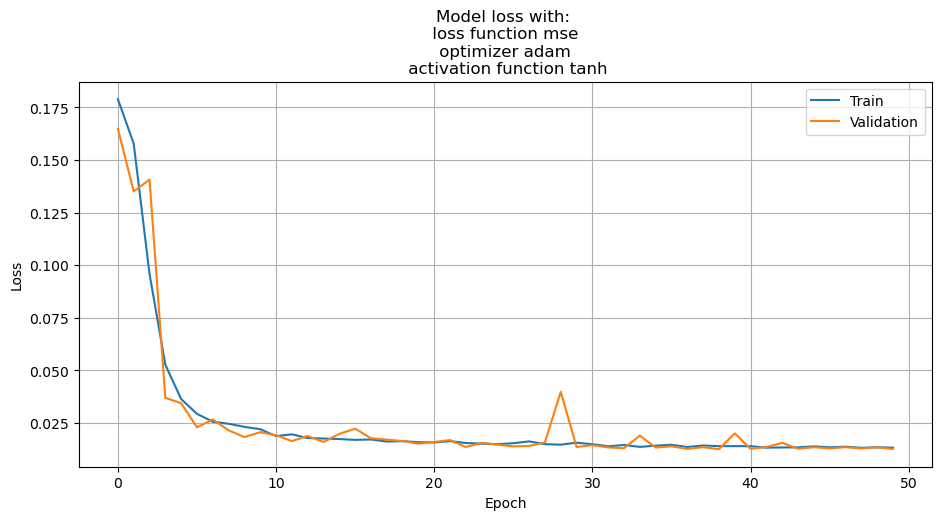

In [15]:
epochs_number = 50
nr_neurons = 20
nr_layers = 5

rows=1
columns=2

model = network_model(nr_neurons, nr_layers, 'adam', 'mse', 'tanh')
#Adam optimization is a stochastic gradient descent method 
#that is based on adaptive estimation of first-order and second-order moments.

merged_train = np.column_stack((x_train, y_train))
merged_valid = np.column_stack((x_valid, y_valid))

history = model.fit(x=merged_train, y=z_train, batch_size=32, epochs=epochs_number, 
                        shuffle=True, validation_data=(merged_valid, z_valid), verbose=0) 

plt.figure(figsize=(11,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss with: \n loss function mse \n optimizer adam \n activation function tanh')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Train', 'Validation'], loc='best')

# evaluate model sui dati di test
score = model.evaluate(merged_valid, z_valid, batch_size=32, verbose=0)
# print performance
print()
print('Model evaluation with test data')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# evaluate model with the exact curve quindi su y_target
score = model.evaluate(merged_valid, z_target, batch_size=32, verbose=0)
# print performance
print()
print('Model evaluation with exact data')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Mostriamo, in ultima istanza, il confronto tra la funzione di target e i dati predetti dal nostro modello.

63/63 [==============================] - 0s 1ms/step


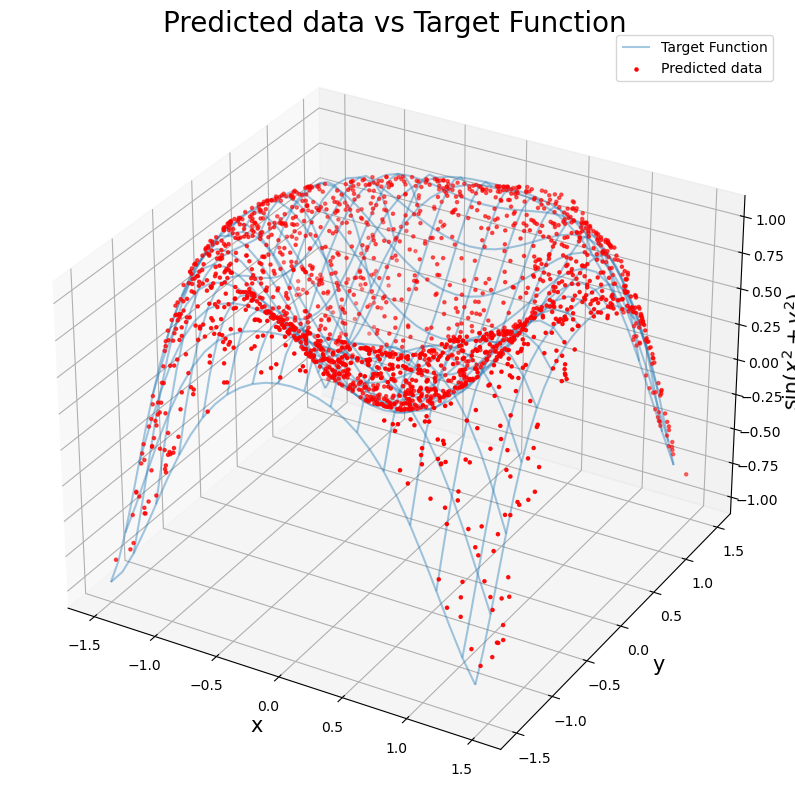

In [18]:
x_predicted = np.random.uniform(-3./2, 3/2, 2000) 
y_predicted = np.random.uniform(-3./2, 3/2, 2000) 
merged_predicted = np.column_stack((x_predicted, y_predicted))
z_predicted = model.predict(merged_predicted)

from mpl_toolkits.mplot3d import axes3d

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

x_surface = np.arange(-3./2, 3./2, 0.1)
y_surface = np.arange(-3./2, 3./2, 0.1)
x_grid, y_grid = np.meshgrid(x_surface, y_surface)
ax.plot_wireframe(x_grid, y_grid, h(x_grid, y_grid), rstride =2, cstride=2, label='Target Function', alpha =0.4)

ax.scatter(x_predicted, y_predicted, z_predicted, color='r', label='Predicted data', marker='.')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15)
ax.set_zlabel(r'sin($x^2+y^2$)', fontsize=15)
plt.title ("Predicted data vs Target Function", fontsize=20, y=1.07)
ax.legend()
plt.show()

Notiamo come per andare ad effettuare un buon fit attraverso la nostra rete neurale, abbiamo dovuto sostituire lo stochastic gradient descent con l'Adam, uno sgd basato su una stima flessibile dei momenti del primo e del secondo ordine, e come funzione di attivazione siamo passati ad una tangente iperbolica che, a differenza della relu, presenta un plateau.

La parte piu' complicata di questo fit e' stata predire l'andamento sulle quattro code della funzione e, nonostante il grande numero di dati di training, 10000, e di neuroni, 100 il che vuol dire oltre 2000 parametri da ottimizzare, possiamo osservare come queste vengano si individuate, ma a malapena popolate. \
Probabilmente, costruendo una rete piu' complessa, con piu strati di diverse dimensioni, e ottimizzando parametri e funzioni per la compilazione, si potrebbe riuscire a predire e fittare bene non solo l'andamento nella pancia, ma anche nelle code. 

Complessivamente, pero', ci riteniamo soddisfatti del lavoro svolto soprattutto perche' siamo riusciti a dare una idea dell'andamento della funzione senza utilizzare un network con un numero enorme di parametri che impiegherebbe sensibilmente piu' tempo ad ottimizzarsi.